In [1]:
%matplotlib inline

In [2]:
import os
from collections import defaultdict
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FIG_DIR, DATA_DIR


In [3]:
figure_data_file = os.path.join(FIG_DIR, 'fig_8_data.csv')

if not os.path.exists(figure_data_file):

    df = pd.read_csv(os.path.join(DATA_DIR, 'MFP.csv'))

    def enlist(lst):
        """ Enlist a mixture of list and str, return as original order"""
        res = []
        for i in lst:
            if isinstance(i, list) or isinstance(i, tuple):
                res.extend(i)
            else:
                if i == i:
                    res.append(i)
        return res


    def user_repeated_cnt_time_bounded(window_size):
        user_repeated = defaultdict(int)
        for user, t in sorted(dic.keys()):
            curr_food = dic[(user, t)]
            prev_food = enlist([dic.get((user, n), [])
                                for n in np.arange(t - (window_size - 1), t, 1)])
            user_repeated[user] += len(set(curr_food) & set(prev_food))
        return user_repeated

    dic = df.groupby(['uid', 'days'])['food_id'].apply(list).to_dict()

    # Or for each user, %repeat consumption = 1- unique/total
    df = df.groupby('uid')['food_id'].apply(list).reset_index()
    time_bound = 7
    user_repeated_cnt = user_repeated_cnt_time_bounded(time_bound)
    df['repeated_cnt_' + str(time_bound)] = df['uid'].apply(lambda s: user_repeated_cnt[s])
    df['n_consumption'] = df['food_id'].apply(len)
    df['n_item'] = df['food_id'].apply(set)
    df['n_item'] = df['n_item'].apply(len)
    df['perc_repeat'] = 1 - df['n_item'] / df['n_consumption']
    df['perc_repeat_7'] = df['repeated_cnt_7'] / df['n_consumption']

    # load profile data
    file_path = os.path.join(DATA_DIR, 'profiles.csv')
    pro_df = pd.read_csv(file_path)

    data = pd.merge(df[['uid', 'perc_repeat_7']], pro_df, on='uid', how='left').fillna('NA')

    data.to_csv(figure_data_file, index=False)


# Plots

In [5]:
def highest_option(factor):
    # at group that is n`ot NA or any
    grp_data = data.groupby(factor)['perc_repeat_7'].mean()
    return [[l for l in grp_data.sort_values(ascending=False).index.tolist() if l != 'NA'][0]]

def plot_fig8(data, cols_ref, context='poster', sharey=True, ncol=3):
    # set background param
    if context == 'paper':
        plt.rc('pdf', fonttype=42)
        sns.set(style="ticks")
        sns.set_context(context, font_scale=1.5)
        figsize = (6, 3)
        c1, c2 = 'darkgrey', 'dimgrey'
    else:
        plt.rc('pdf')
        sns.set(style="whitegrid")
        sns.set_context(context, font_scale=0.8)
        figsize = (12, 6)
        c1, c2 = sns.color_palette("Paired")[:2]

    fig, axs = plt.subplots(1, ncol, figsize=figsize)

    for i, d in enumerate(cols_ref):
        factor, xlabel, order, xticks = d
        curr_df = data[['perc_repeat_7', factor]]
        curr_df2 = deepcopy(curr_df)
        curr_df2[factor] = 'Any'
        curr_df = curr_df[curr_df[factor] != 'NA']
        curr_df = pd.concat([curr_df, curr_df2]).reset_index()

        sig_options = highest_option(factor)
        my_colors = {o: c1 for o in order}
        my_colors.update({o: c2 for o in sig_options})

        ax = sns.barplot(x=factor, y='perc_repeat_7', data=curr_df, order=order,
                         palette=my_colors, ax=axs[i])
        if context == 'paper':
            ax.grid(ls="dotted")
            ax.set(ylim=(.3, .48))
        else:
            ax.grid(axis='x', ls='')
            ax.set(ylim=(.3, .45))

        ax.set_xlabel(xlabel)
        ax.set(xticklabels=xticks)

        if i == 0:
            ax.set_ylabel("% Repeat consumption")
        else:
            ax.set_ylabel("")
            if sharey:
                ax.set(yticklabels=[])

    sns.despine(offset=10, trim=True)

    # save figure
    fig.tight_layout()
    if context == "paper":
        figure_name = os.path.join(FIG_DIR, 'paper_fig_8.png')
    else:
        figure_name = os.path.join(FIG_DIR, 'fig_8.png')
    plt.savefig(figure_name, dpi=200, transparent=False, bbox_inches='tight', pad_inches=0.0)
    plt.show()


In [6]:
data = pd.read_csv(figure_data_file)
cols_ref = [('gender', 'Gender', ['Male', 'Female'], ['Male', 'Female']),
            ('age_group', 'Age groups', ['18-44', '45+'], ['18-44', '45+']),
            ('regions_us', 'US Regions', ['Northeast', 'Midwest', 'South', 'West'], ['NE', 'MW', 'S', 'W'])]


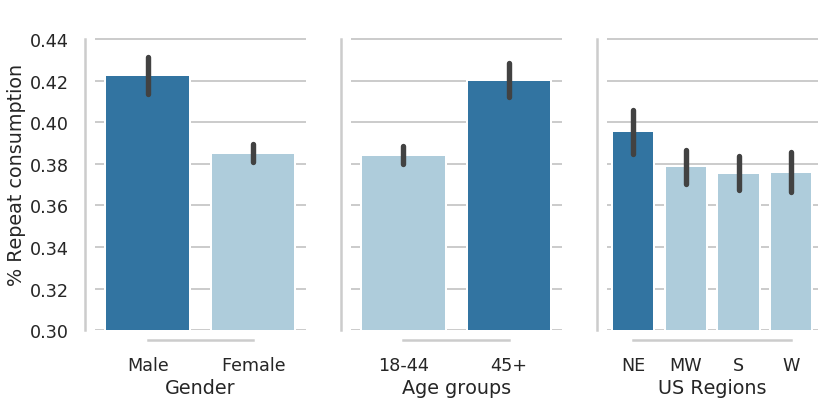

In [7]:
plot_fig8(data, cols_ref, context='poster')

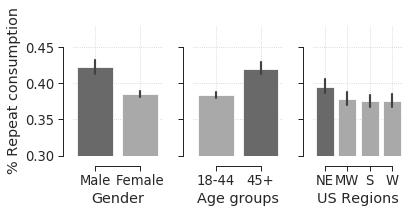

In [8]:
plot_fig8(data, cols_ref, context='paper')